In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
os.environ['OMP_NUM_THREADS'] = '14'
from collections import OrderedDict
import re
from sklearn.mixture import GaussianMixture
from DualGMMFEM import *
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib
from matplotlib import cm


In [2]:
FEM_dict=pd.read_pickle('D:/0210_Phase_II/II_txt2tensor/Outputs/Simple_shear/SH_Set_I_Dict.pkl')
FEM_dict_list=sort_list(list(FEM_dict.keys()))

    
FEM_graph_weights=OrderedDict()
#for model in tqdm(FEM_dict_list):
# Select FEM model
model=FEM_dict_list[0]

In [3]:
#Recap the info of CZEs
SCZEs=FEM_dict[model]['Sets']['STRONG_CZE_CE_ELEMENT_SET'].astype(int)
WCZEs=FEM_dict[model]['Sets']['WEAK_CZE_CE_ELEMENT_SET'].astype(int)
CZEs=np.vstack([SCZEs,WCZEs])
CZEs=CZEs[CZEs[:, 0].argsort()]
Solids=FEM_dict[model]['Sets']['CEMENT_ELEMENT_SET'].astype(int)
temporal_dict=FEM_dict[model]['Time']
#For plots
FEM_frame_nodes=FEM_dict[model]['Time']['T=0']['COORD']
stress=FEM_dict[model]['Time']['T=20']['S'][:,1:]

In [4]:
#Obtain the stress in solid elements
n,_=Solids.shape
sElt=stress[:n,:]

In [5]:
#Obtain the elementary centers
#i=0
eltCenters=[]
for i in range(Solids.shape[0]):
    node_ids=Solids[i,1:]-1
    triangle_vertices=FEM_frame_nodes[node_ids,1:]
    eltCenters.append(triangle_vertices.mean(0))
eltCenters=np.vstack(eltCenters)

In [6]:
fig,ax=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, stress[:,0],titlelabel=[r'Heatmap of $\sigma_{11}$ Component from FEM in MPa', ''])


In [7]:
position_stress=np.hstack([eltCenters,sElt])
stress_idx=0
cluster_target=position_stress[:, [0, 1, stress_idx + 2]]
gmm1,gmm2,labels,idices,final_labels,[vmax,vmin,vscale]=GMM2(cluster_target)

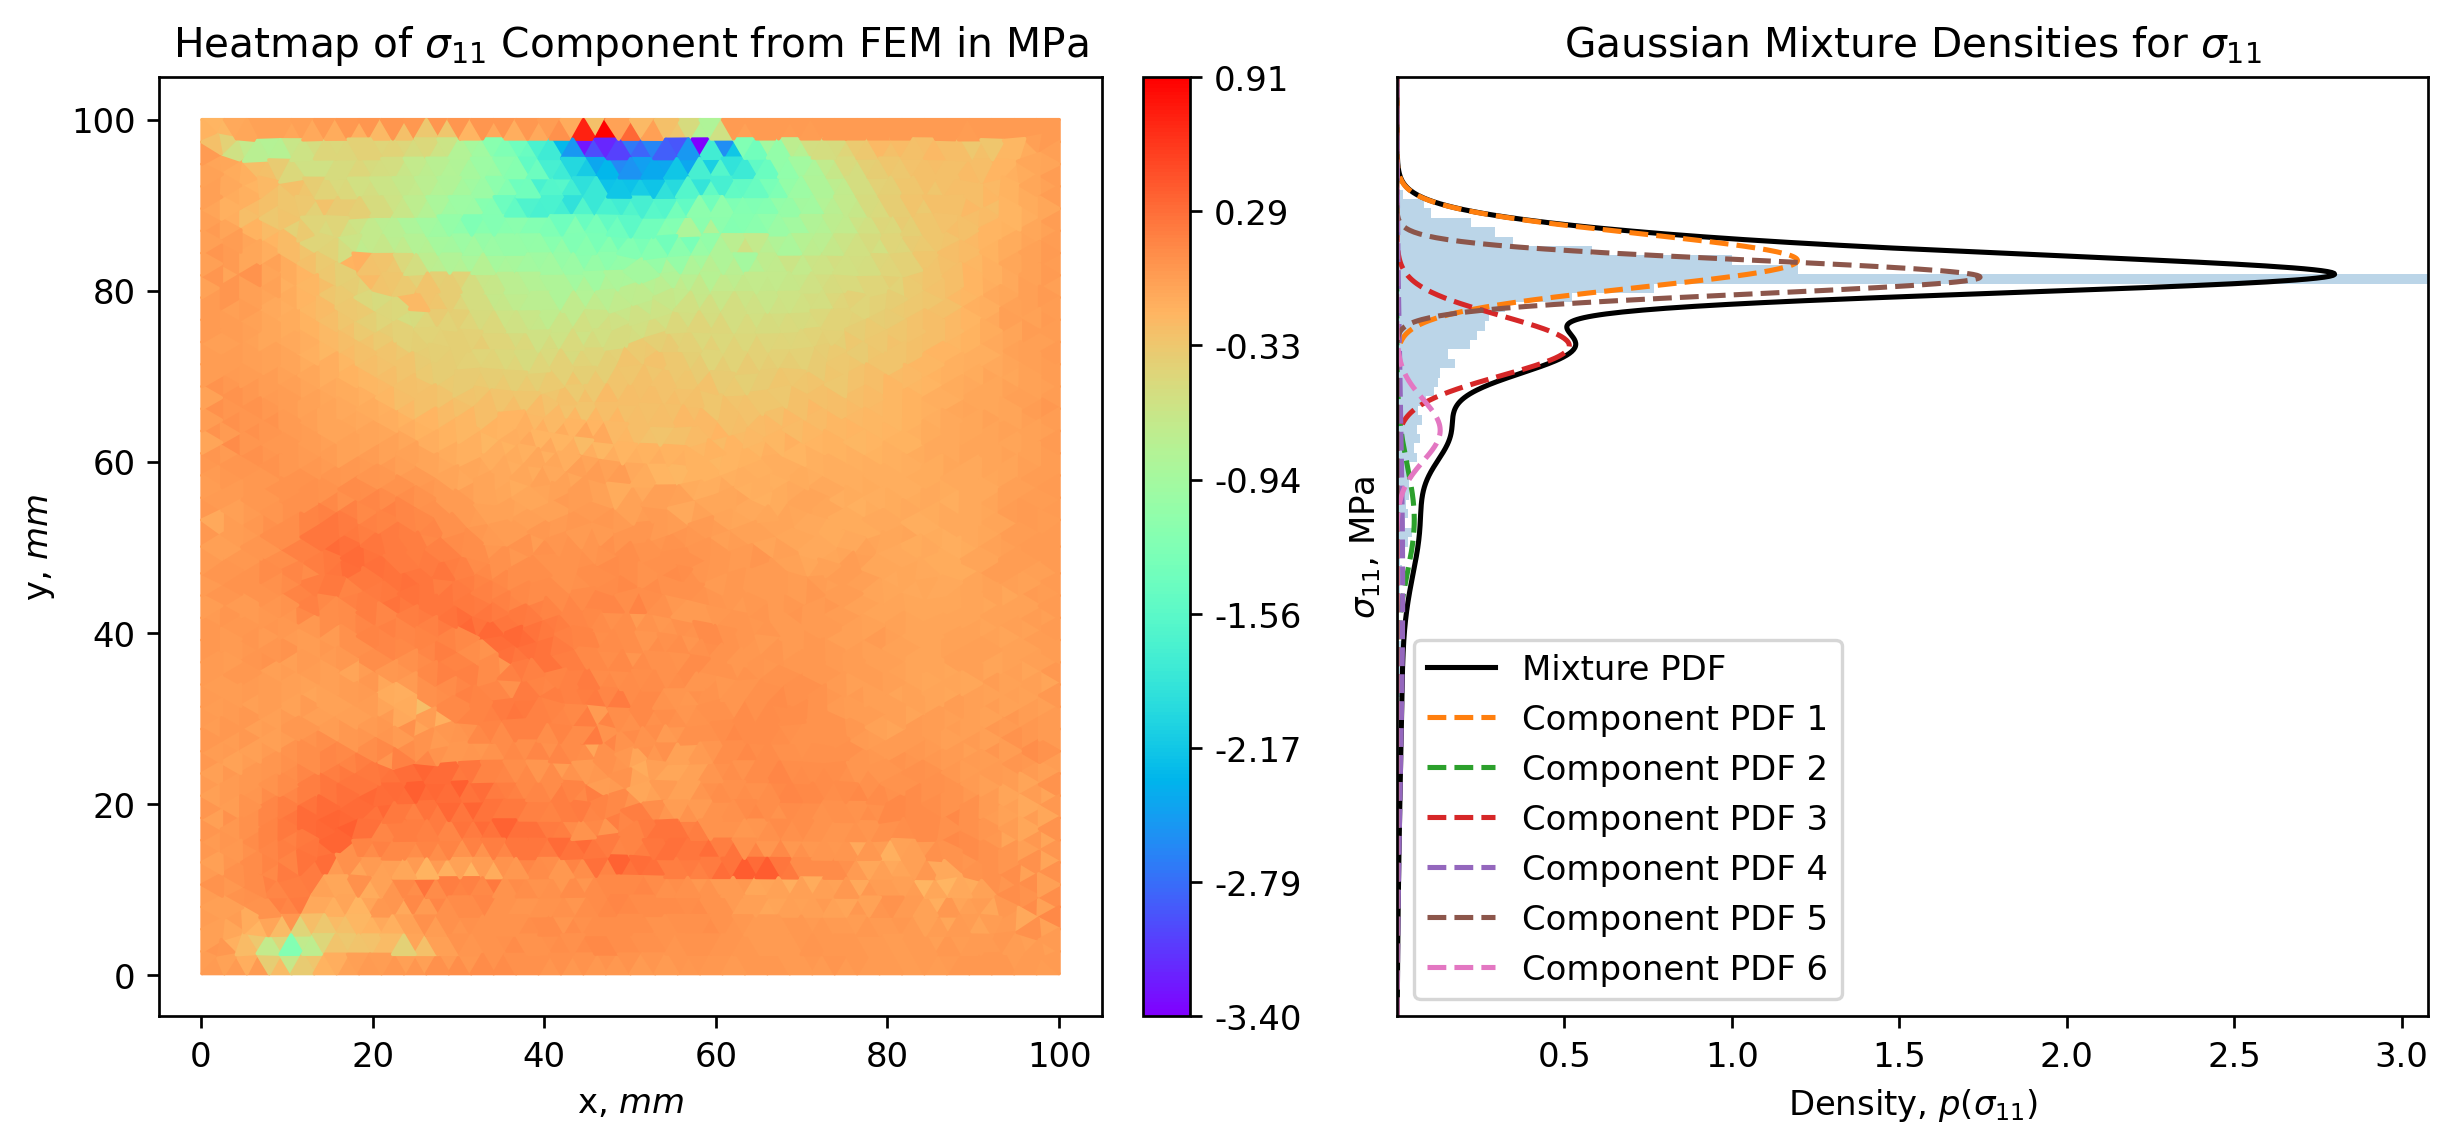

In [8]:
GMM_1D_plot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, stress[:,0], gmm1)

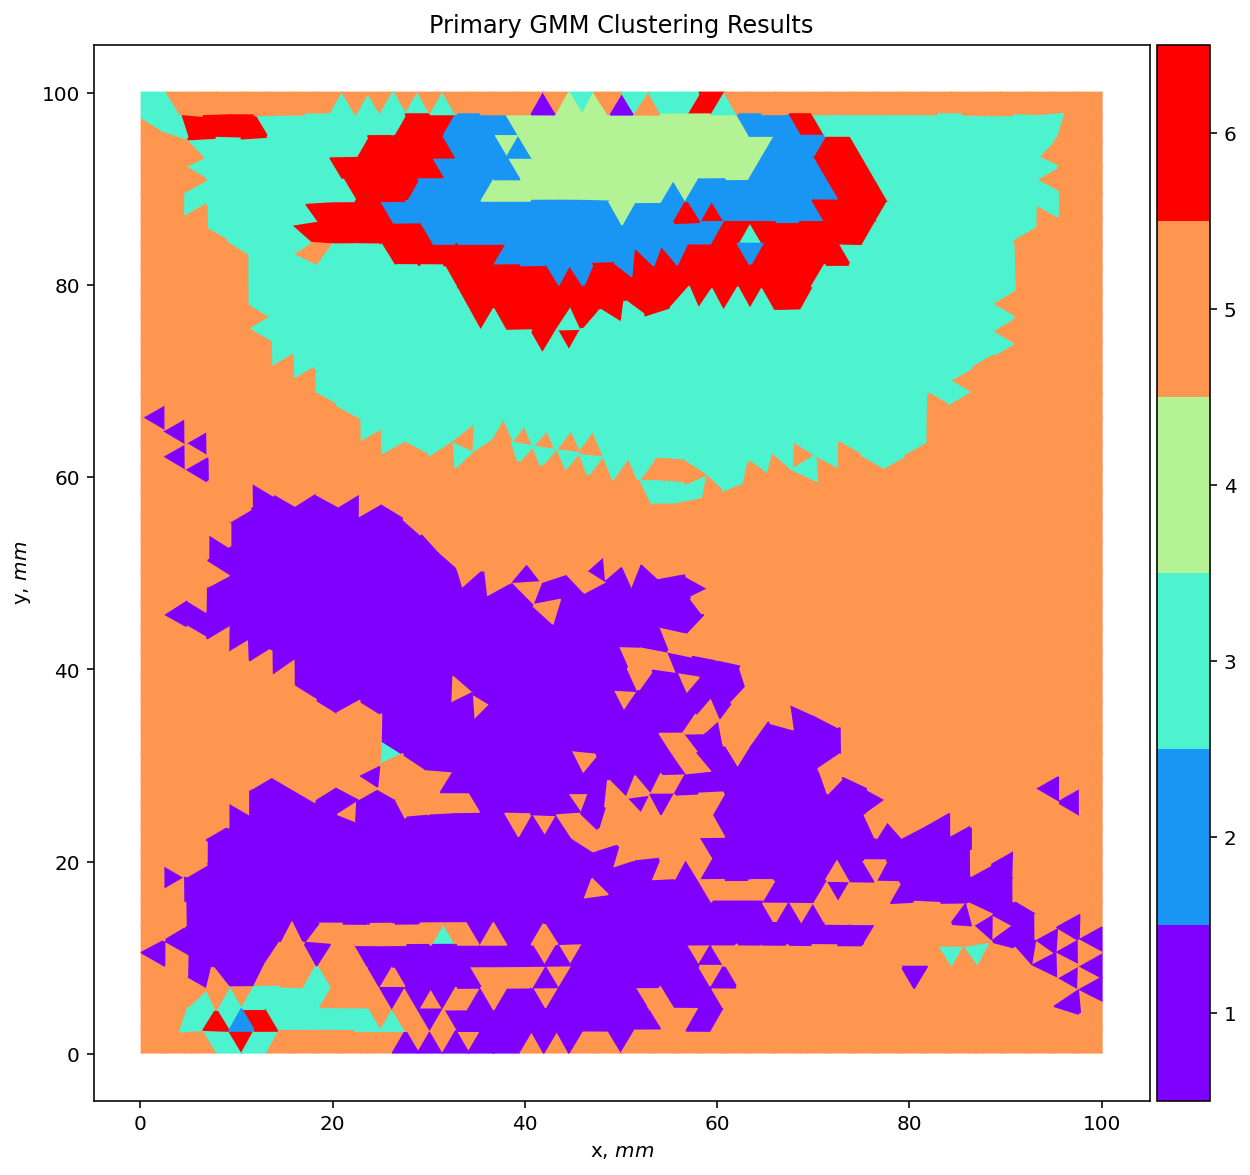

In [9]:
figp1,axp1=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, labels+1,titlelabel=['Primary GMM Clustering Results',''],discrete_bar=True)
figp1

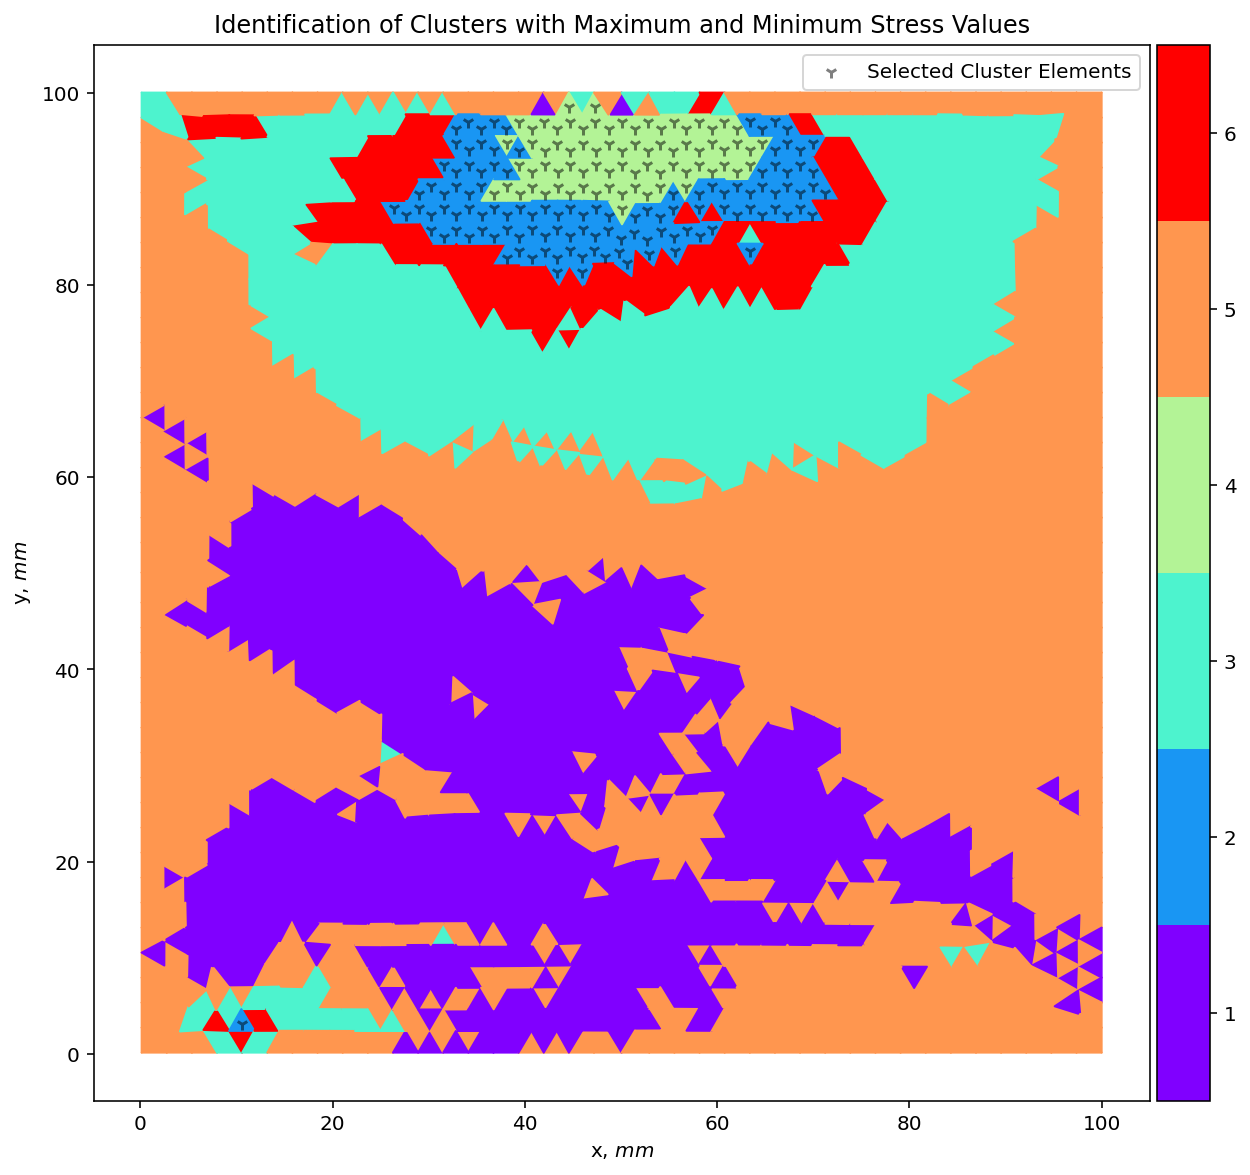

In [10]:
figp1_mark,axp1_mark=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, labels+1,titlelabel=['Identification of Clusters with Maximum and Minimum Stress Values',''],discrete_bar=True)
axp1_mark.scatter(eltCenters[idices,0],eltCenters[idices,1],color='k',marker='1',label='Selected Cluster Elements',alpha=0.5)
axp1_mark.legend()
figp1_mark

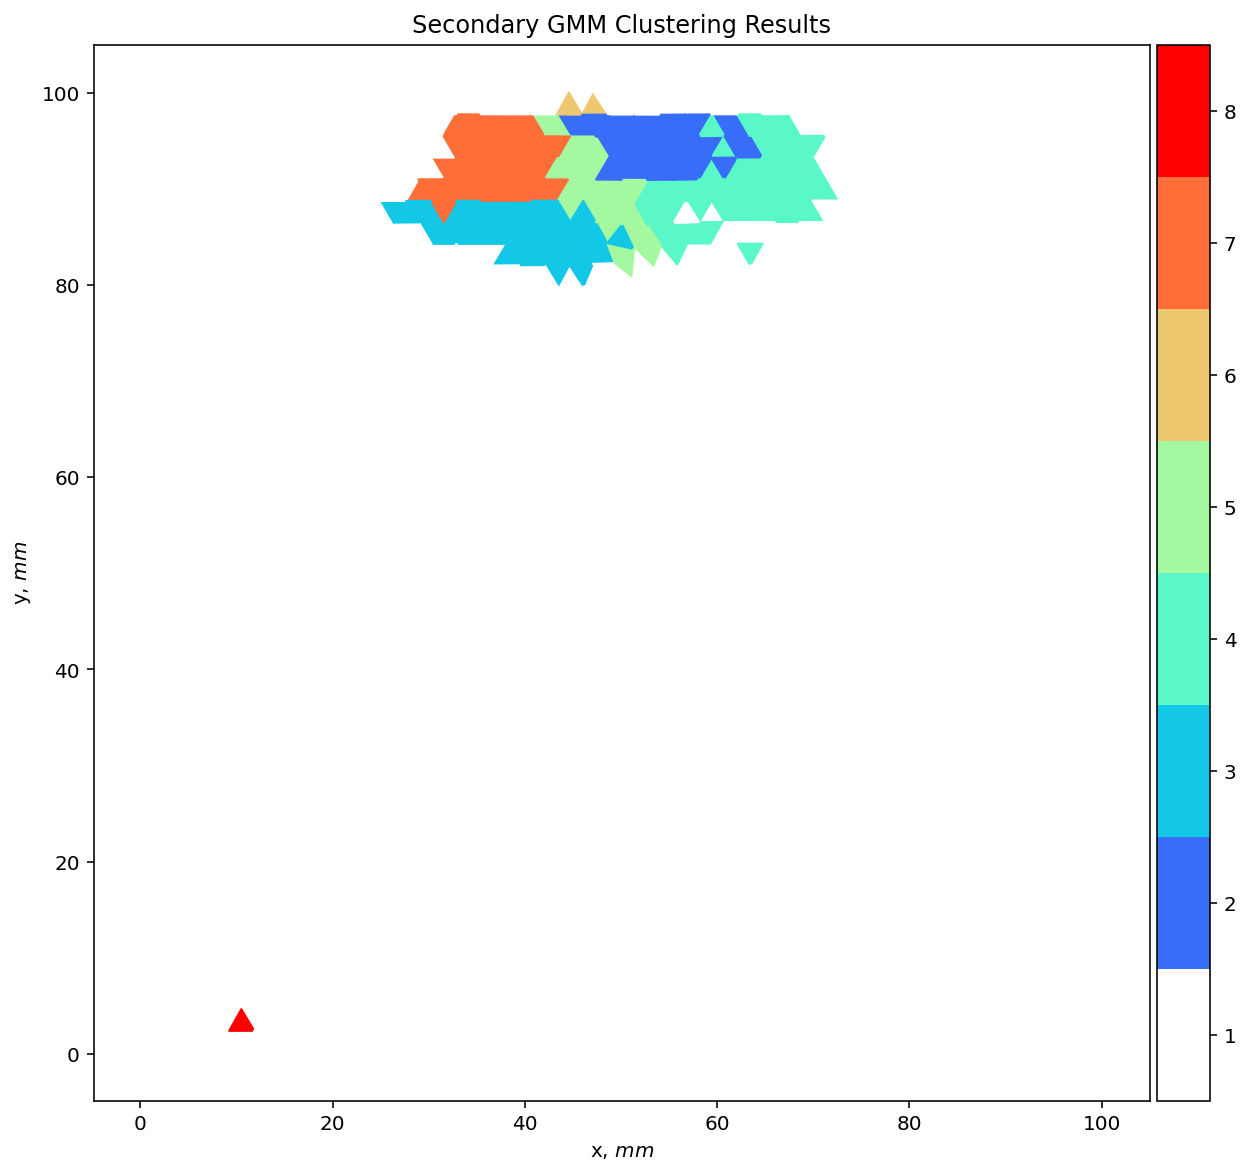

In [11]:
figp2,axp2=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, final_labels.reshape(-1)+1,titlelabel=['Secondary GMM Clustering Results',''],discrete_bar=True,zero_white=True)
figp2

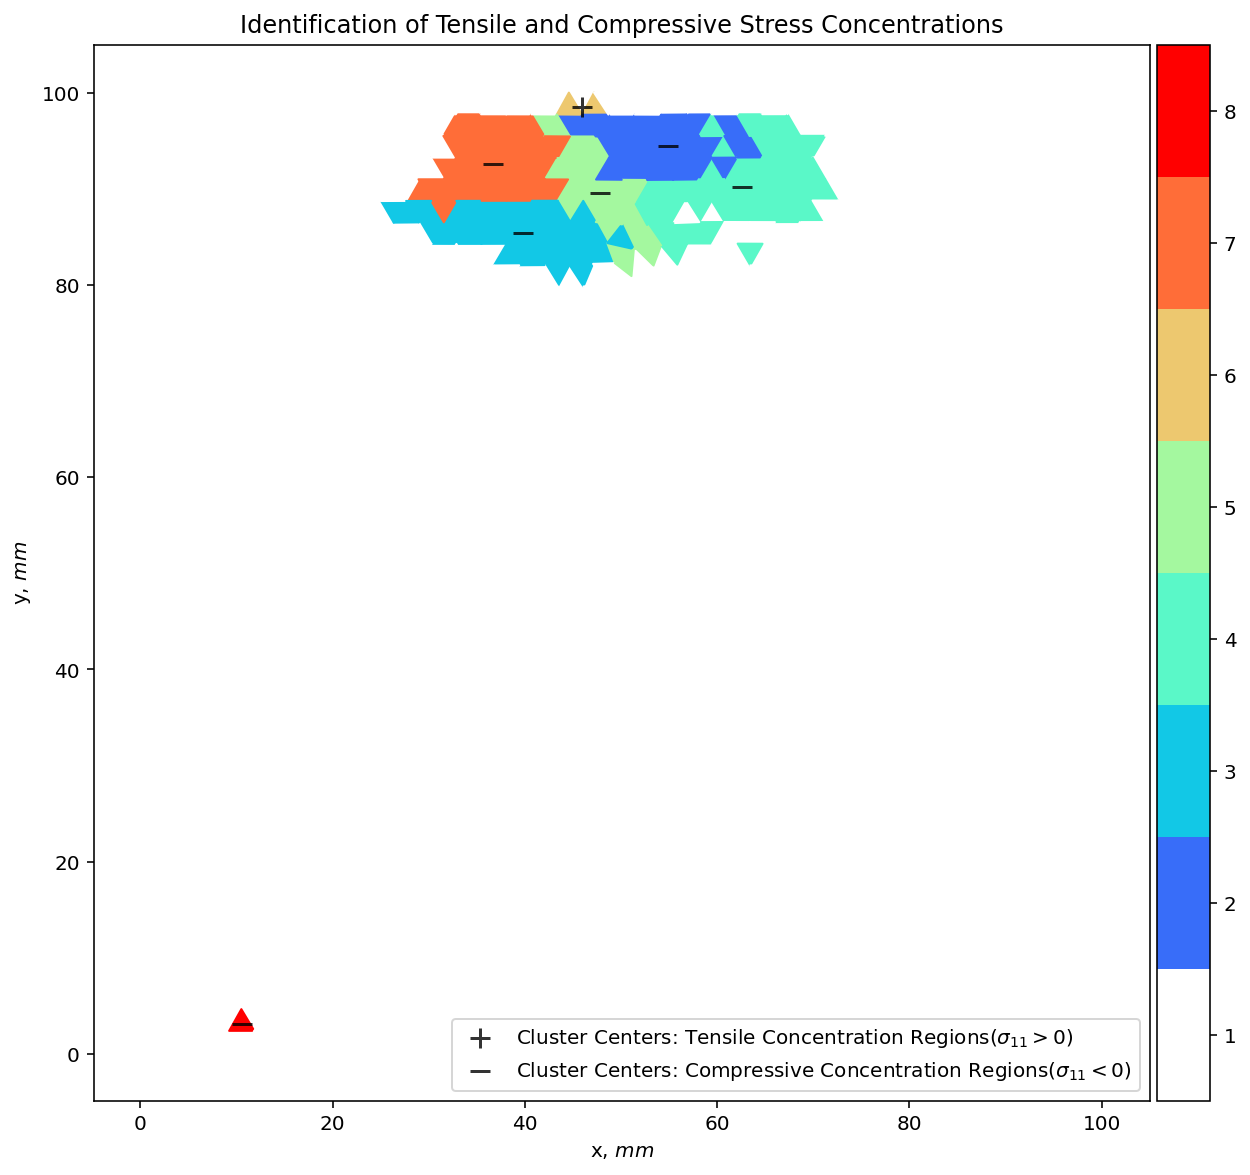

In [12]:
figp2_mark,axp2_mark=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, final_labels.reshape(-1)+1,titlelabel=['Identification of Tensile and Compressive Stress Concentrations',''],discrete_bar=True,zero_white=True)
retriClusterCenStress=gmm2.means_[:,-1]/vscale*(vmax-vmin)+vmin
axp2_mark.scatter(gmm2.means_[retriClusterCenStress>0,0],gmm2.means_[retriClusterCenStress>0,1],color='k',marker='+',label=r'Cluster Centers: Tensile Concentration Regions$(\sigma_{11}>0)$',alpha=0.8,s=100)
axp2_mark.scatter(gmm2.means_[retriClusterCenStress<0,0],gmm2.means_[retriClusterCenStress<0,1],color='k',marker='_',label=r'Cluster Centers: Compressive Concentration Regions$(\sigma_{11}<0)$',alpha=0.8,s=100)
axp2_mark.legend(loc='lower right')
figp2_mark

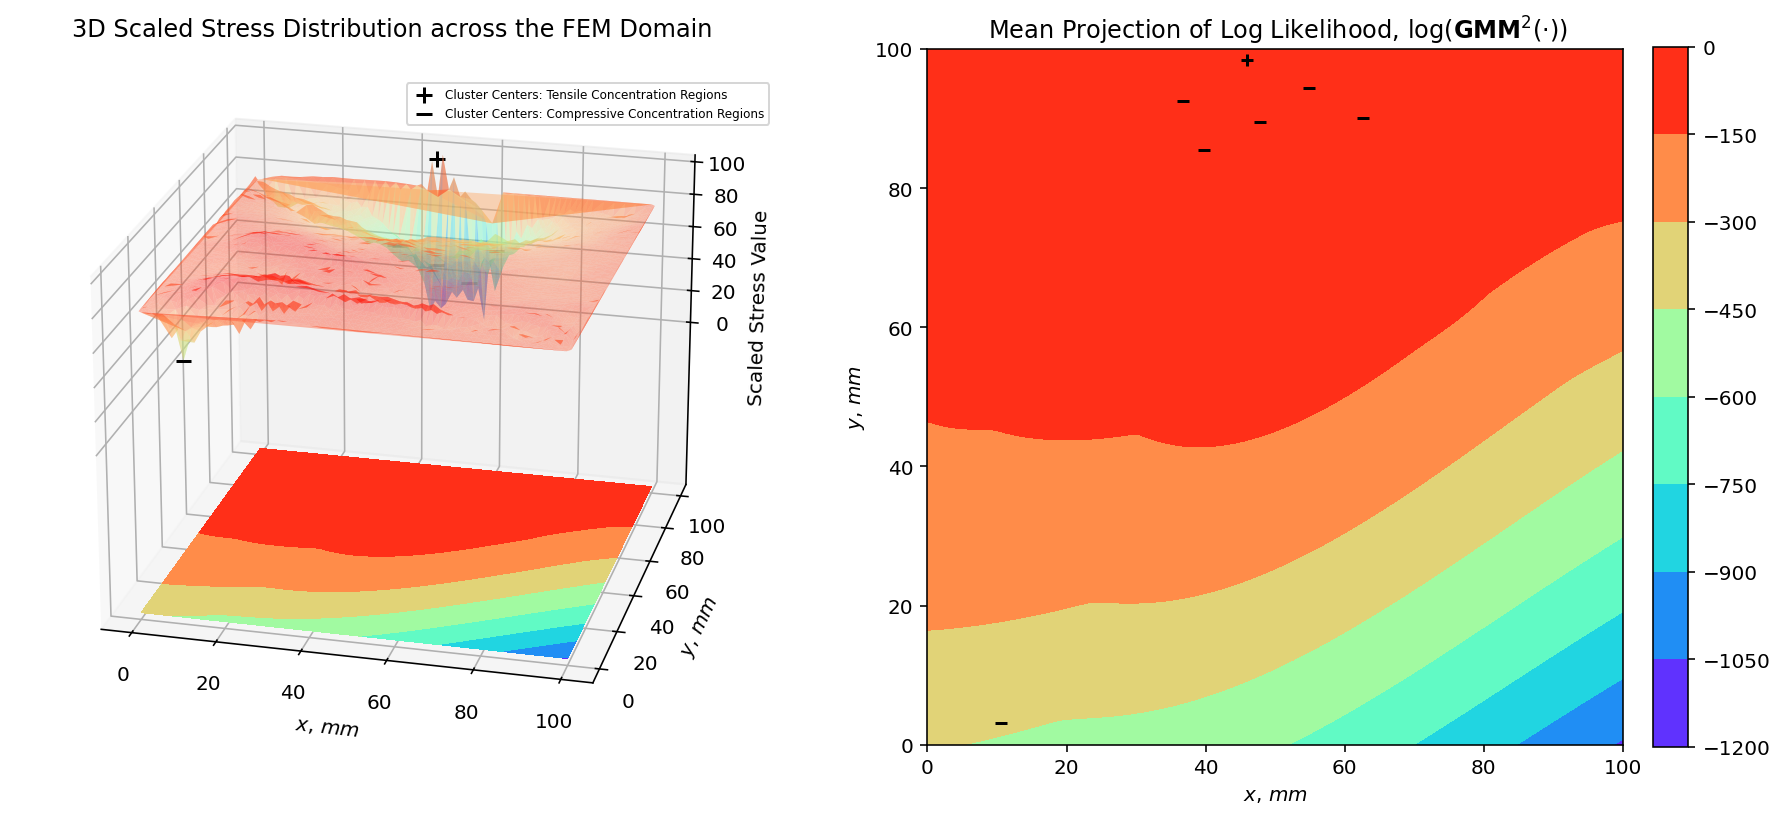

In [13]:
fig3d,Z_score=plot_projectionGMM(cluster_target,gmm2,retriClusterCenStress)
fig3d

In [55]:

kmin1=4
kmax1=10
kmin2=3
kmax2=12
#Start here
#Phase I:
phaseI_tar=cluster_target[:,[-1]]##
k1,bic1_fig=optimal_k_gmm_bic(phaseI_tar,kmin=kmin1,kmax=kmax1)##
gmm1=GaussianMixture(n_components=k1,max_iter=1000,init_params='k-means++')##
labels=gmm1.fit_predict(phaseI_tar)##



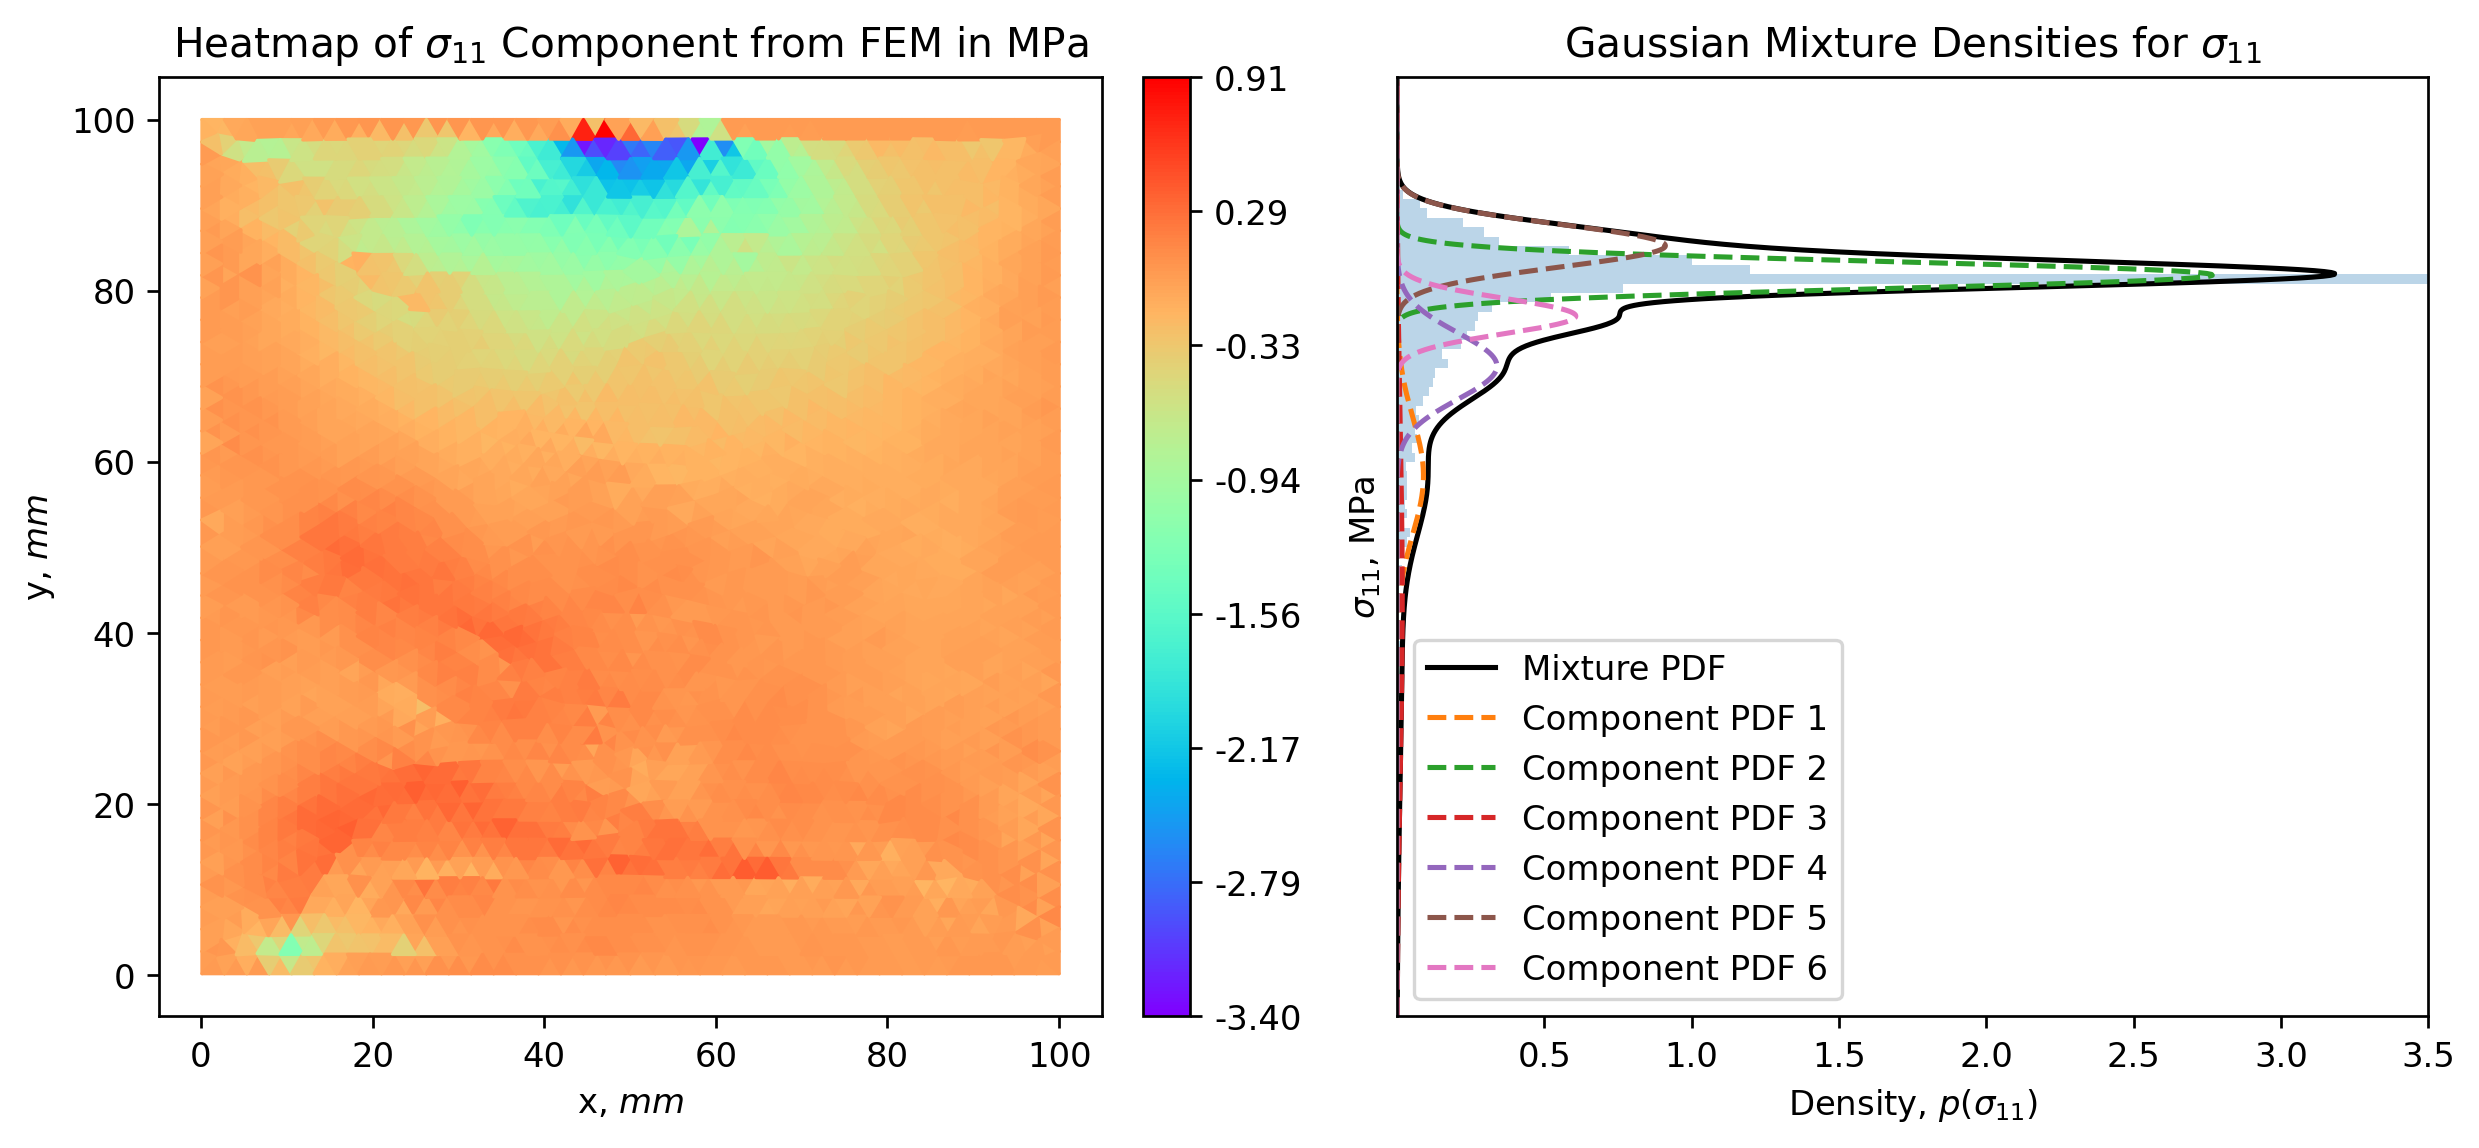

In [56]:

GMM_1D_plot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, stress[:,0], gmm1)

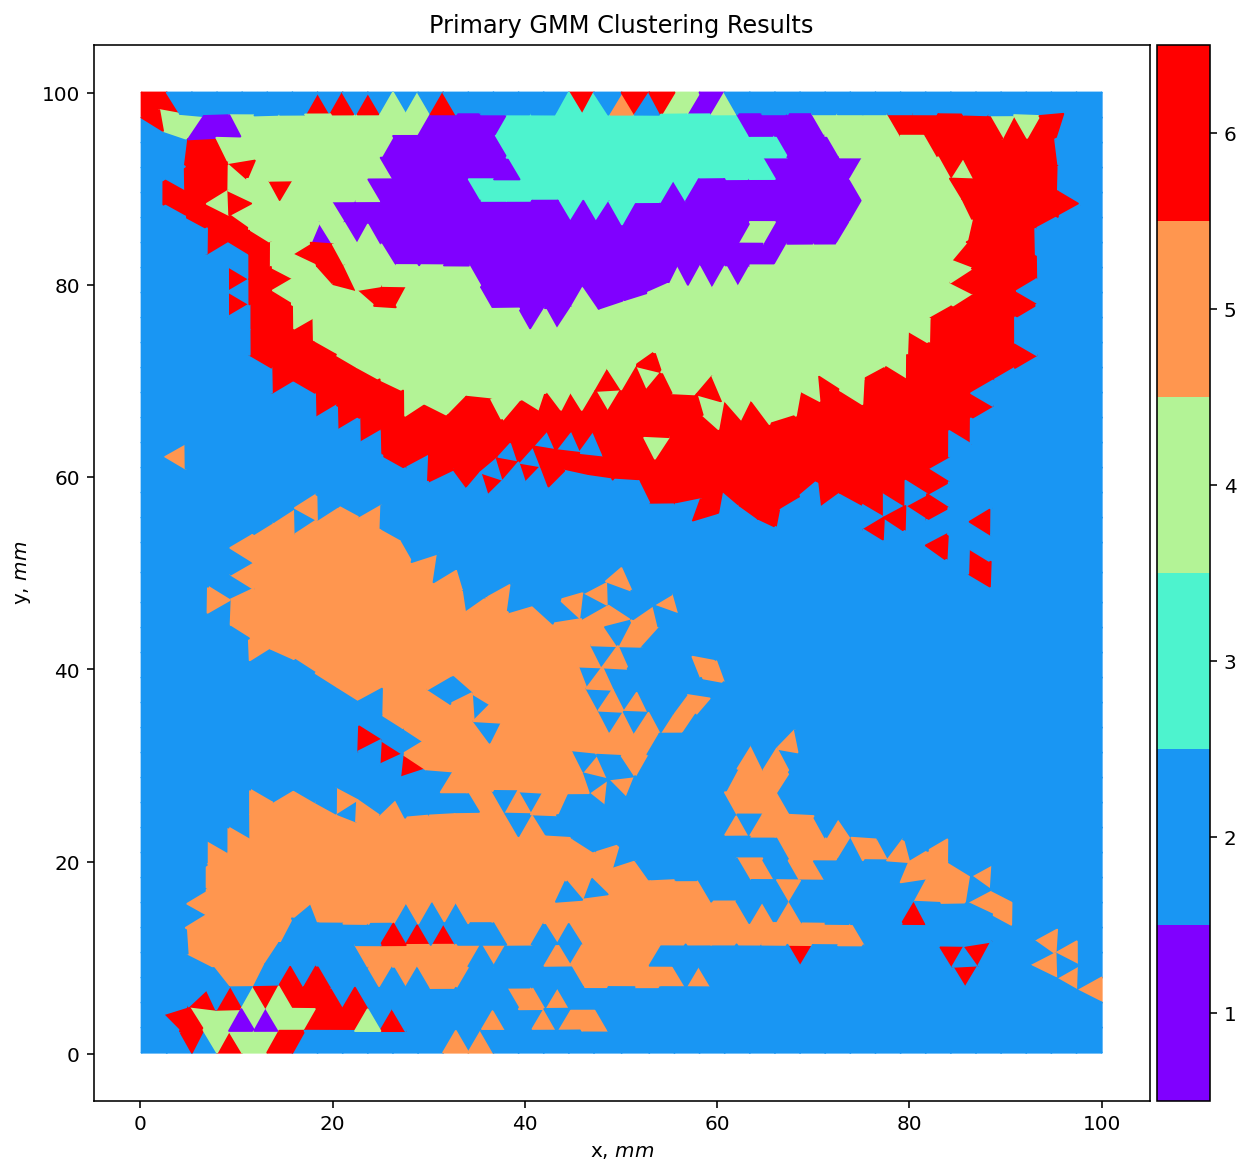

In [57]:

figp1,axp1=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, labels+1,titlelabel=['Primary GMM Clustering Results',''],discrete_bar=True)
figp1

In [58]:
##Phase I, post
min_center_clusters=gmm1.predict(phaseI_tar.min().reshape(1, -1)).item()
max_center_clusters=gmm1.predict(phaseI_tar.max().reshape(1, -1)).item()
idices_min=np.where(labels==min_center_clusters)  
idices_max=np.where(labels==max_center_clusters)
#print(f'Min_idx:{min_center_clusters+1},Max_idx:{max_center_clusters+1}')
if min_center_clusters==max_center_clusters:
    clusterCount = np.bincount(labels)
    min_size_clusters=np.argwhere(clusterCount==np.unique(clusterCount)[0])
    idices1=[]
    for i in min_size_clusters:
        idices1.append(np.where(labels==i))   
    idices1=np.hstack([idices1]).reshape(-1)
    min_2ed_size_clusters=np.argwhere(clusterCount==np.unique(clusterCount)[1])
    idices2=[]
    for i in min_2ed_size_clusters:
        idices2.append(np.where(labels==i))   
    idices2=np.hstack([idices2]).reshape(-1)           
    
    idices=np.hstack([idices1,idices2]).reshape(-1)
else:
    idices=np.hstack([idices_max,idices_min]).reshape(-1)
##

In [68]:
min_center_clusters#==max_center_clusters

2

In [60]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=int64)

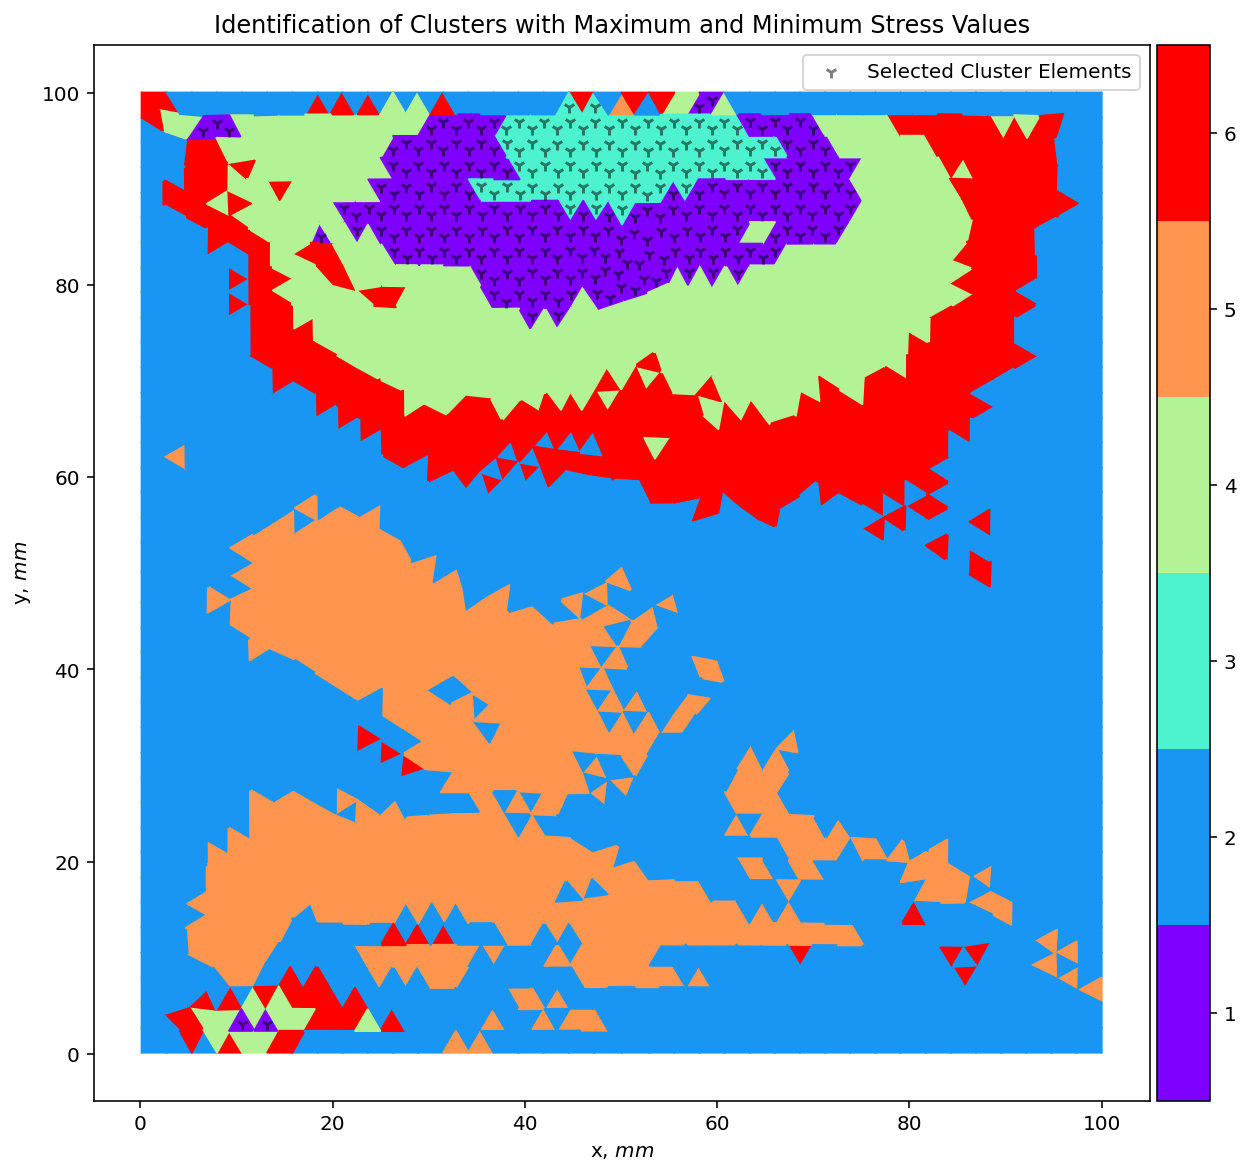

In [67]:
figp1_mark,axp1_mark=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, labels+1,titlelabel=['Identification of Clusters with Maximum and Minimum Stress Values',''],discrete_bar=True)
axp1_mark.scatter(eltCenters[idices,0],eltCenters[idices,1],color='k',marker='1',label='Selected Cluster Elements',alpha=0.5)
axp1_mark.legend()
figp1_mark
#figp1

In [69]:
## Phase II
phaseII_tar=cluster_target[idices,:].copy()
#Normalized the stress dim
last_column=phaseII_tar[:,-1]
vmax,vmin,vscale=[last_column.max(),last_column.min(),phaseII_tar[:,:-1].max()]
phaseII_tar[:,-1]=(last_column-vmin)/(vmax-vmin)*vscale#Normalize the final column

In [70]:

k2,bic2_fig=optimal_k_gmm_bic(phaseII_tar,kmin=kmin2,kmax=kmax2)
#bic2_fig
gmm2=GaussianMixture(n_components=k2,max_iter=1000)
labels2=gmm2.fit_predict(phaseII_tar)
#Reformulate the final labels
final_labels=np.zeros([len(cluster_target),1])
final_labels[idices]=(labels2+1).reshape(-1,1)

d:\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Wi

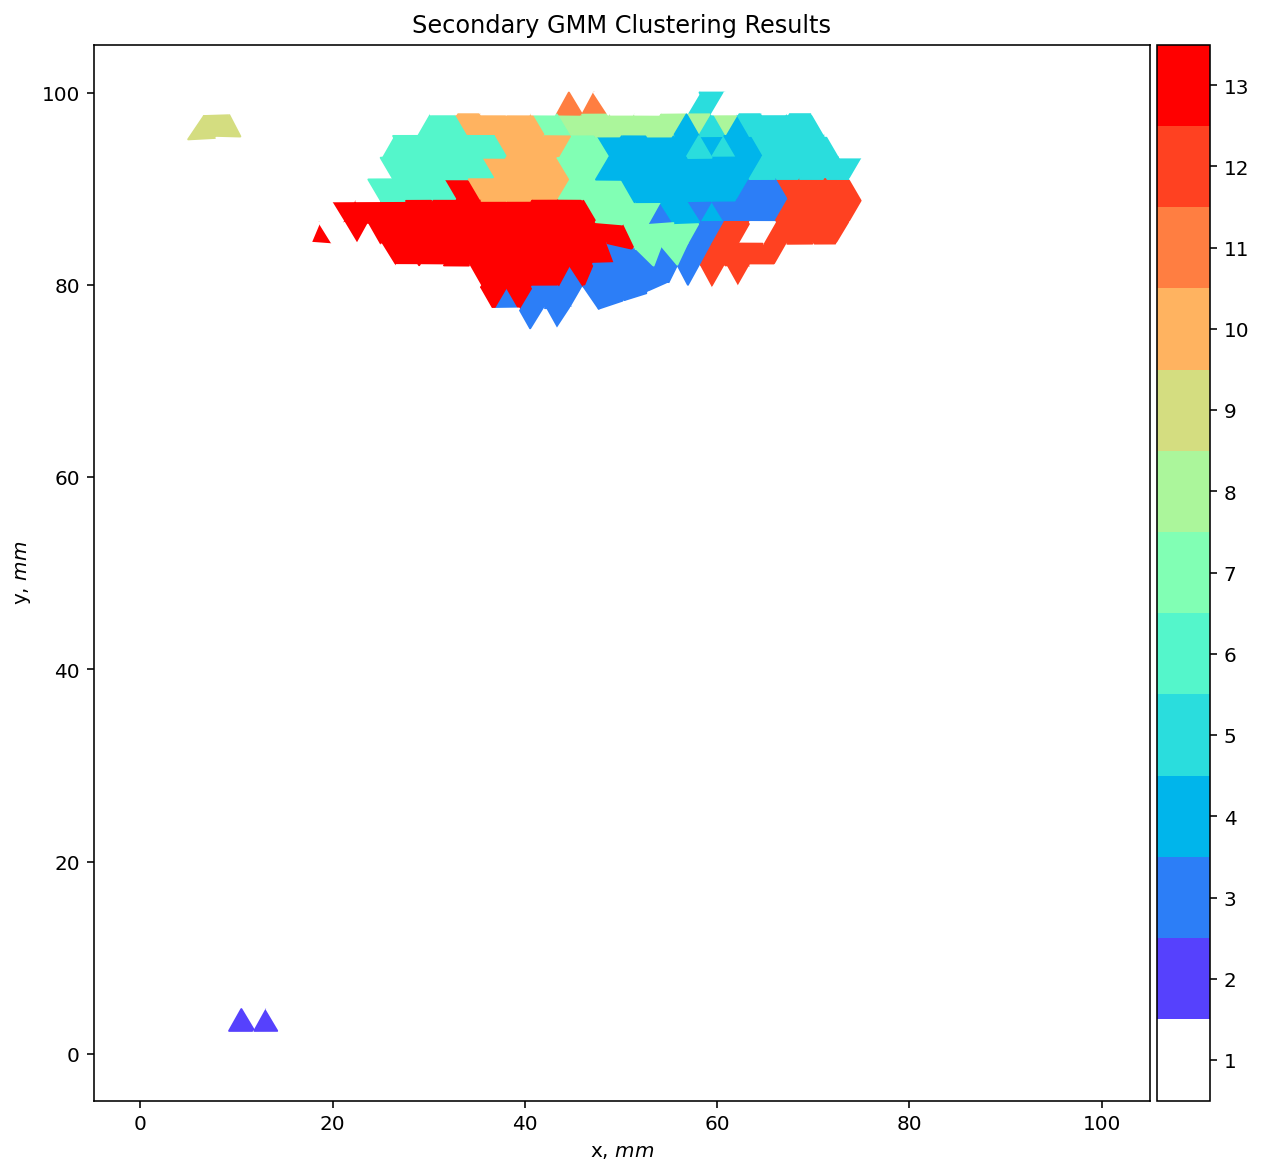

In [71]:
figp2,axp2=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, final_labels.reshape(-1)+1,titlelabel=['Secondary GMM Clustering Results',''],discrete_bar=True,zero_white=True)
figp2

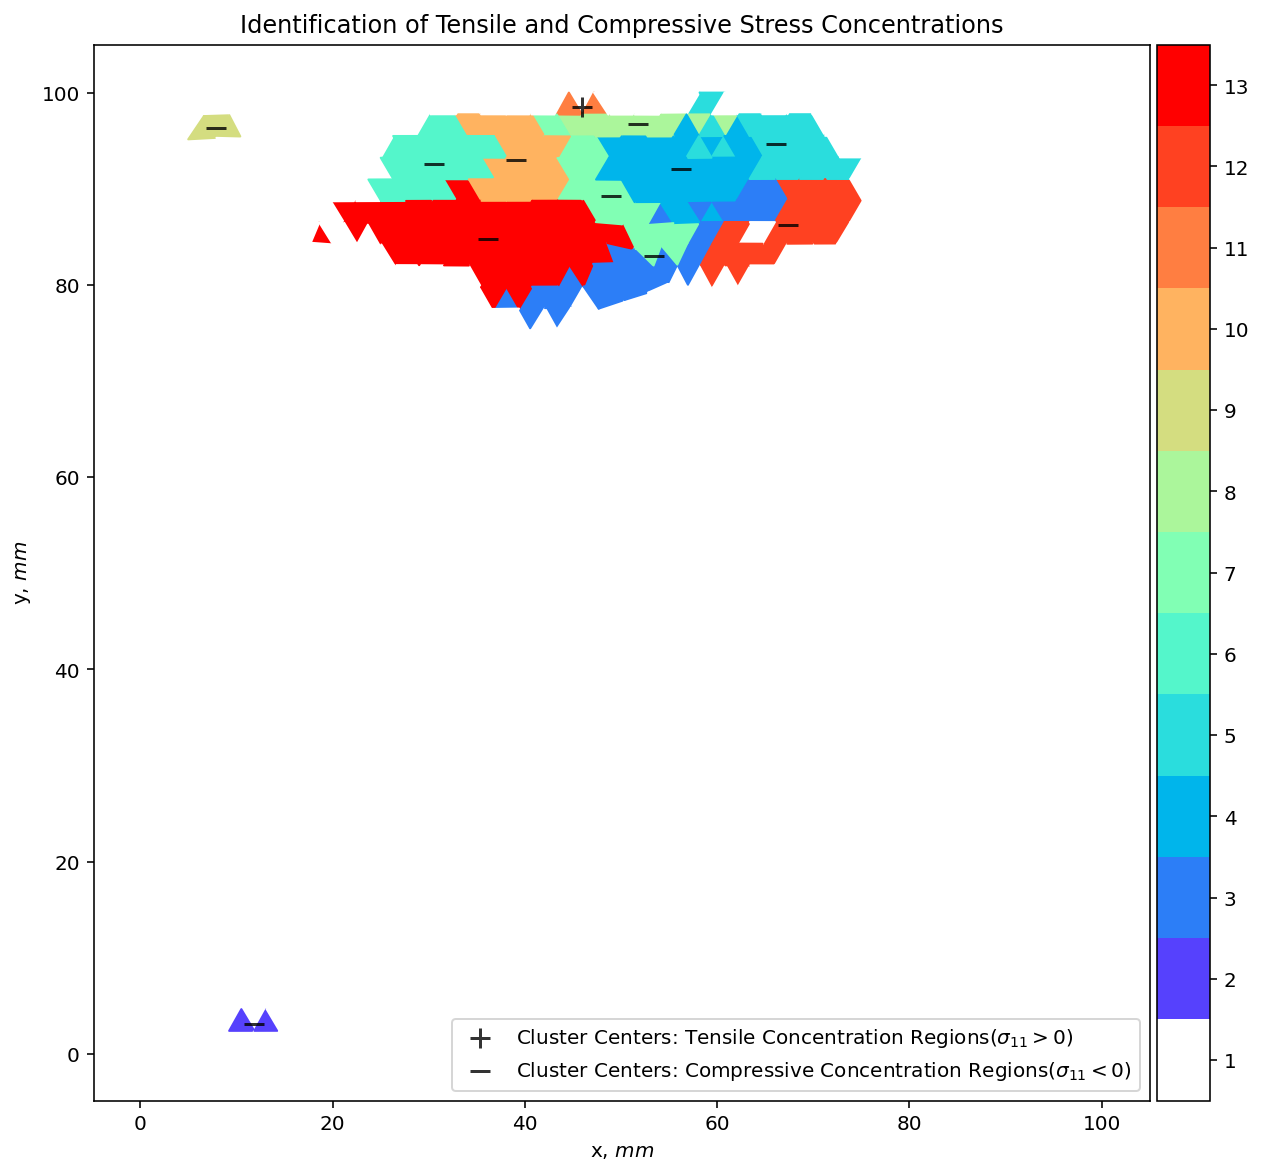

In [142]:
figp2_mark,axp2_mark=showMeshPlot(FEM_frame_nodes[:,1:], Solids[:,1:]-1, final_labels.reshape(-1)+1,titlelabel=['Identification of Tensile and Compressive Stress Concentrations',''],discrete_bar=True,zero_white=True)
retriClusterCenStress=gmm2.means_[:,-1]/vscale*(vmax-vmin)+vmin
axp2_mark.scatter(gmm2.means_[retriClusterCenStress>0,0],gmm2.means_[retriClusterCenStress>0,1],color='k',marker='+',label=r'Cluster Centers: Tensile Concentration Regions$(\sigma_{11}>0)$',alpha=0.8,s=100)
axp2_mark.scatter(gmm2.means_[retriClusterCenStress<0,0],gmm2.means_[retriClusterCenStress<0,1],color='k',marker='_',label=r'Cluster Centers: Compressive Concentration Regions$(\sigma_{11}<0)$',alpha=0.8,s=100)
axp2_mark.legend(loc='lower right')
figp2_mark


array([[ 0.44943866],
       [ 0.48761255],
       [ 0.36014985],
       [-1.13995055],
       [-1.39368188],
       [-1.64974279],
       [ 0.39209923],
       [ 0.16552471],
       [ 0.46348249],
       [ 0.45118262]])

In [156]:
def plot_projectionGMM(x_c,gmm2,retriClusterCenStress):
    input=x_c.copy()
    input=input[:,:3]
    input[:,-1]=(input[:,-1]-input[:,-1].min())/(input[:,-1].max()-input[:,-1].min())*input[:,0].max()
    xlim=[0,100]
    ylim=[0,100]
    spatial_means=gmm2.means_

    fig3d = plt.figure(figsize=(15,10),dpi=144,facecolor='white')
    #first
    ax = fig3d.add_subplot(121, projection='3d')   #Origianl stress
    fig3d.text(0.3, 0.75, '3D Scaled Stress Distribution across the FEM Domain', ha='center', va='center', fontsize=12)
    ax.scatter(spatial_means[retriClusterCenStress>0,0],spatial_means[retriClusterCenStress>0,1],spatial_means[retriClusterCenStress>0,-1], color='k', s=60,marker='+',label=r'Cluster Centers: Tensile Concentration Regions')
    ax.scatter(spatial_means[retriClusterCenStress<0,0],spatial_means[retriClusterCenStress<0,1],spatial_means[retriClusterCenStress<0,-1], color='k', s=60,marker='_',label=r'Cluster Centers: Compressive Concentration Regions')
    surf = ax.plot_trisurf( input[:,0],input[:,1], input[:,-1],alpha=0.4,cmap=cm.rainbow)
    #The local concentration of Gaussian via average projection
    N = 100
    col = np.linspace(xlim[0],xlim[1] , N)
    row = np.linspace(ylim[0],ylim[1] , N)
    Z = np.linspace(ylim[0],ylim[1] , N)
    colm, rowm, Zm= np.meshgrid(col, row, Z)

    samples = np.array([colm.ravel(),rowm.ravel(), Zm.ravel()]).T
    Z_score=gmm2.score_samples(samples)
    z_oper=Z_score.reshape(N,N,N)
    cset = ax.contourf(colm[:,:,0],rowm[:,:,0], z_oper.mean(-1), zdir='z', offset=-100, cmap=cm.rainbow)
    ax.set_zlim(xlim[0]-100,xlim[-1])
    ax.set_xlabel('$x$, $mm$')
    ax.set_ylabel('$y$, $mm$' )
    ax.set_zlabel('Scaled Stress Value')
    ax.legend(loc='upper right', fontsize="6", bbox_to_anchor=(0.5, 0.42, 0.5, 0.5)) 
    #ax.invert_yaxis()
    ticks=np.linspace(ylim[0],ylim[1],6)
    ticks=[int(i) for i in ticks]
    ax.set_yticks(ticks)

    ax.set_zticks(ticks)
    elev = 22 # Elevation angle in degrees
    azim = -76  # Azimuthal angle in degrees
    ax.view_init(elev=elev, azim=azim)
    #Second
    ax = fig3d.add_subplot(122)
    im3=ax.contourf(row,col,z_oper.mean(-1), cmap=cm.rainbow)
    ax.scatter(spatial_means[retriClusterCenStress>0,0],spatial_means[retriClusterCenStress>0,1], color='k',marker='+')
    ax.scatter(spatial_means[retriClusterCenStress<0,0],spatial_means[retriClusterCenStress<0,1], color='k',marker='_')

    fig3d.text(0.71, 0.75, r'Mean Projection of Log Likelihood, $\log(\mathbf{GMM}^2(\cdot))$', ha='center', va='center', fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.set_yticks(ticks)

    ax.set_xlabel('$x$, $mm$')
    ax.set_ylabel('$y$, $mm$' )
    cbar3 = fig.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)

    plt.close()
    return fig3d,Z_score
fig3d,Z_score=plot_projectionGMM(cluster_target,gmm2,retriClusterCenStress)

In [157]:
Z_score
z_oper=Z_score.reshape(100,100,100)

In [158]:
z_oper.shape

(100, 100, 100)

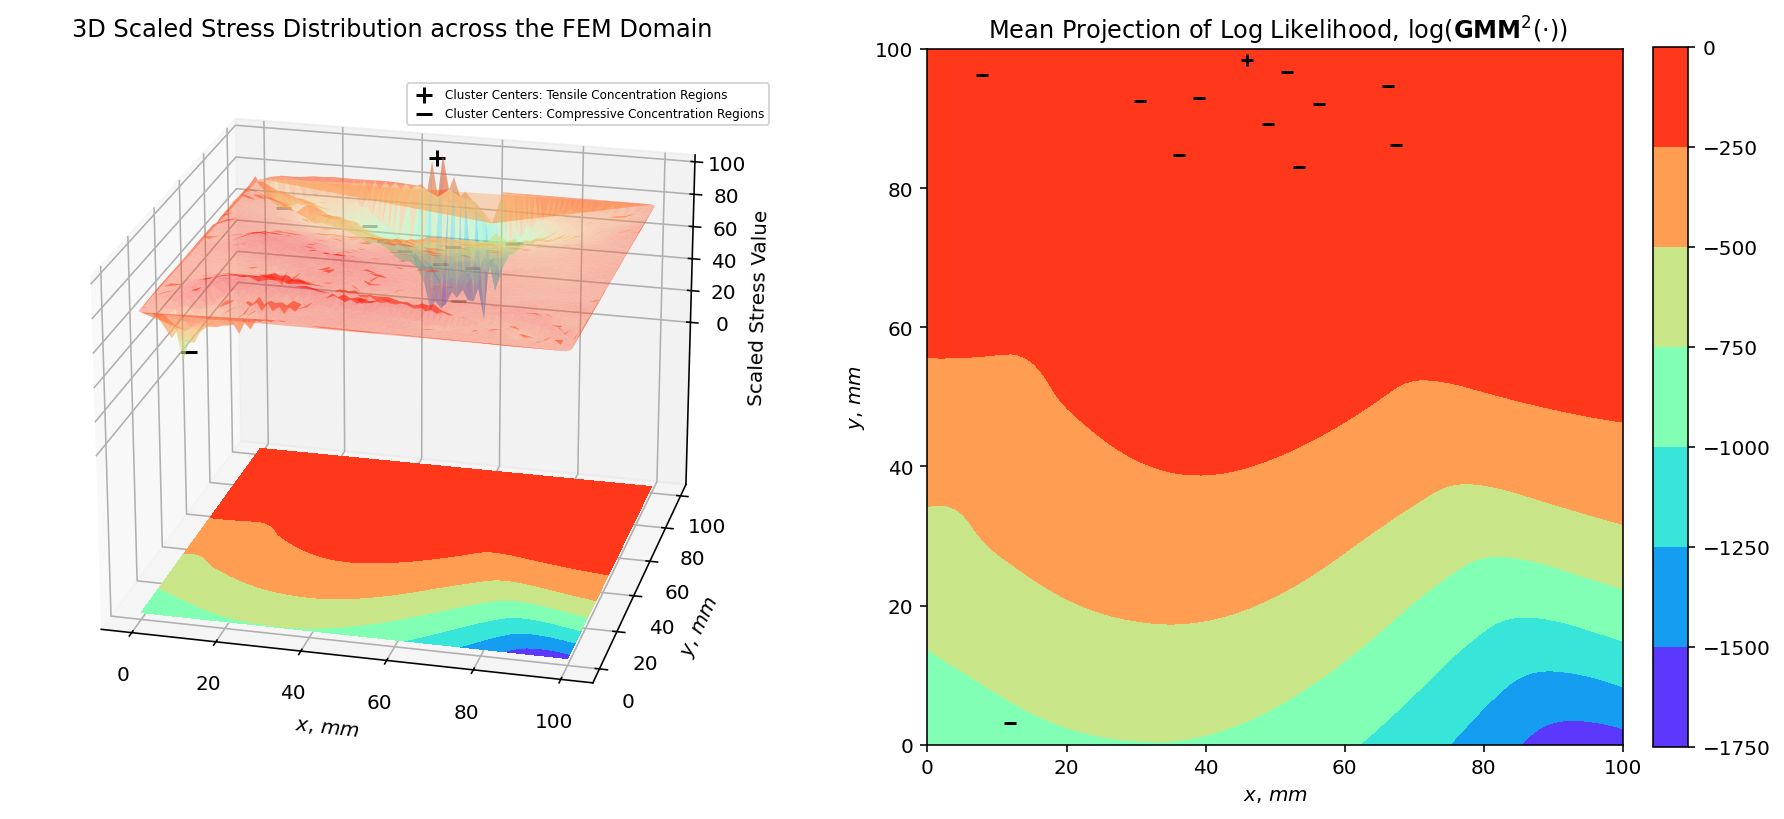

In [159]:
fig3d

In [162]:
xlim=[0,100]
ylim=[0,100]
N = 2
col = np.linspace(xlim[0],xlim[1] , N)
row = np.linspace(ylim[0],ylim[1] , N)
Z = np.linspace(ylim[0],ylim[1] , N)
colm, rowm, Zm= np.meshgrid(col, row, Z)

samples = np.array([colm.ravel(),rowm.ravel(), Zm.ravel()]).T

In [163]:
samples

array([[  0.,   0.,   0.],
       [  0.,   0., 100.],
       [100.,   0.,   0.],
       [100.,   0., 100.],
       [  0., 100.,   0.],
       [  0., 100., 100.],
       [100., 100.,   0.],
       [100., 100., 100.]])

In [165]:
Z_score=gmm2.score_samples(samples)
z_oper=Z_score.reshape(N,N,N)
Z_score

array([-1692.34055429,  -561.85074463, -1245.3534617 , -1184.42712866,
        -146.33786084,   -99.98714598,   -81.86551443,   -71.08792898])

In [171]:
z_oper[:,:,1]

array([[ -561.85074463, -1184.42712866],
       [  -99.98714598,   -71.08792898]])

In [ ]:
def GMM_square_algorithm_f(x2d,kmin1=4,kmax1=8,kmin2=3,kmax2=9,demon_func=None,demoBool=False):
    #Preprocess for primary clustering
    x_c=get_position_values_matrix(x2d)
    x_cluster_target=(x_c[:,-1].reshape(-1, 1))

    # The primary clusters
    #k1,fig_optimal_k=optimal_k_silhouette(x_cluster_target,kmin=2,kmax=6,mode='gmm')
    k1,_=optimal_k_gmm_bic(x_cluster_target,kmin=kmin1,kmax=kmax1)

    gmm1=GaussianMixture(n_components=k1,max_iter=1000)
    labels=gmm1.fit_predict(x_cluster_target)
    #centers=gmm1.means_

    clustered_imgs=cluster_img_matrix(x2d,x_c,labels)
    #fig_vs_clusters=plot_clusters_x(x2d,clustered_imgs,labels)

    #Post process for primary clustering
    min_center_clusters=gmm1.predict(x2d.min().reshape(1, -1)).item()
    max_center_clusters=gmm1.predict(x2d.max().reshape(1, -1)).item()
    idices_min=np.where(labels==min_center_clusters)  
    idices_max=np.where(labels==max_center_clusters)
    #print(f'Min_idx:{min_center_clusters+1},Max_idx:{max_center_clusters+1}')
    if min_center_clusters==max_center_clusters:
        clusterCount = np.bincount(labels)
        min_size_clusters=np.argwhere(clusterCount==np.unique(clusterCount)[0])
        idices1=[]
        for i in min_size_clusters:
            idices1.append(np.where(labels==i))   
        idices1=np.hstack([idices1]).reshape(-1)
        min_2ed_size_clusters=np.argwhere(clusterCount==np.unique(clusterCount)[1])
        idices2=[]
        for i in min_2ed_size_clusters:
            idices2.append(np.where(labels==i))   
        idices2=np.hstack([idices2]).reshape(-1)           
        
        idices=np.hstack([idices1,idices2]).reshape(-1)
    else:
        idices=np.hstack([idices_max,idices_min]).reshape(-1)
    #print(f'The two clusters are:{np.unique(labels[idices])}')
    #For positon clusters
    xy_xc=x_c.clone()
    last_column=xy_xc[:,-1]
    xy_xc[:,-1]=(last_column-last_column.min())/(last_column.max()-last_column.min())*xy_xc[:,:-1].max()#Normalize the final column
    #For second values clusters
    second_cluster_target=xy_xc[idices,:]

    # The secondary clusters
    k2,_=optimal_k_gmm_bic(second_cluster_target,kmin=kmin2,kmax=kmax2)

    #Second round clustering via Gaussian mixture

    gmm=GaussianMixture(n_components=k2,max_iter=1000)
    second_labels=gmm.fit_predict(second_cluster_target)

    #Recap the final labels for plotting
    final_labels=np.zeros([len(xy_xc),1])
    final_labels[idices]=(second_labels+1).reshape(-1,1)
    clustered_imgs_gmm2=cluster_img_matrix(x2d,x_c,final_labels.reshape(-1))
    #fig_vs_clusters_gmm=plot_clusters_x(x2d,clustered_imgs_gmm,final_labels)
    x_c=np.hstack([x_c,labels.reshape(-1,1),final_labels])

    if demoBool:
        fig=demon_func(x2d,clustered_imgs,labels,clustered_imgs_gmm2,final_labels)
        #fig=final_plot_clusters_x(x2d,clustered_imgs,labels,clustered_imgs_gmm2,final_labels)
        concentration_f=plot_All_concentration_trand(clustered_imgs_gmm2,gmm)
        return x_c,gmm1,gmm,clustered_imgs_gmm2,fig,concentration_f,[x2d,clustered_imgs,labels,clustered_imgs_gmm2,final_labels]
    else:
        return x_c,gmm